In [ ]:
!pip install brisque scikit-image matplotlib


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 3.2 MB/s eta 0:00:00
  Created wheel for libsvm-official: filename=libsvm_official-3.35.0-cp310-cp310-linux_x86_64.whl size=124214 sha256=a70671d1049b03615259d06dbd2aec8f779ee000b3d33003de7e6998a2860913
  Stored in directory: /root/.cache/pip/wheels/ec/50/a6/962c82577759a39080b2d0b51640bc1be45d02bd5d0d5dde7d
Successfully built libsvm-official


In [ ]:
# ==========================
# 1) Gerekli Kütüphaneler
# ==========================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from brisque import BRISQUE
import math
from skimage.filters import threshold_otsu
from skimage import morphology

# Skimage içerisindeki bazı fonksiyonlar (entropy hesaplamak vb.)
from skimage.filters import rank
from skimage.morphology import disk
from skimage import exposure

# Google Colab kullanıyorsanız:
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline


# ==========================
# 2) Yardımcı Fonksiyonlar
# ==========================

def apply_mask(img, mask):
    """
    Maskeyi uygular: Retina dışındaki kısımları 0'a (siyah) çeker.
    """
    bin_mask = (mask > 128).astype(np.uint8)
    bin_mask_3ch = cv2.merge([bin_mask, bin_mask, bin_mask])
    masked_img = img * bin_mask_3ch
    return masked_img


# ------------ NORMALİZASYONLAR ------------
def minmax_normalization(img):
    """
    Min-Max norm: (x - min) / (max - min)
    """
    img_float = img.astype(np.float32)
    min_val = np.min(img_float)
    max_val = np.max(img_float)
    eps = 1e-8
    normalized_img = (img_float - min_val) / (max_val - min_val + eps)
    normalized_img = (normalized_img * 255).astype(np.uint8)
    return normalized_img

def l1_normalization(img):
    """
    L1 norm: piksel değerlerinin toplamına bölerek normalize eder
    """
    eps = 1e-8
    norm = np.sum(img) + eps
    normalized_img = img / norm
    normalized_img = (normalized_img * 255).astype(np.uint8)
    return normalized_img

def l2_normalization(img):
    """
    L2 norm: piksel değerlerinin karelerinin toplamının kareköküne bölerek normalize eder
    """
    eps = 1e-8
    norm = np.sqrt(np.sum(img**2)) + eps
    normalized_img = img / norm
    normalized_img = (normalized_img * 255).astype(np.uint8)
    return normalized_img


# ------------ YUMUŞATMA (SMOOTHING) ------------
def mean_filter(img, ksize=3):
    """
    Mean (ortalama) filtre
    """
    return cv2.blur(img, (ksize, ksize))

def median_filter(img, ksize=3):
    """
    Median filtre
    """
    return cv2.medianBlur(img, ksize)

def adaptive_median_filter(img, ksize=3):
    """
    BilateralFilter -> adaptif bir filtrenin benzeri gibi kullanıyoruz
    """
    return cv2.bilateralFilter(img, d=ksize, sigmaColor=75, sigmaSpace=75)


# ------------ KESKİNLEŞTİRME & KENAR HARİTALARI ------------
def sobel_edge(img):
    """
    Sobel kenar tespiti
    """
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = cv2.magnitude(sobelx, sobely)
    sobel_mag = cv2.convertScaleAbs(sobel_mag)
    return sobel_mag

def canny_edge(img, low_threshold=100, high_threshold=200):
    """
    Canny kenar tespiti
    """
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    return edges

def laplacian_edge(img):
    """
    Laplacian kenar tespiti
    """
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    lap = cv2.convertScaleAbs(lap)
    return lap


# ---- Entropi, Range, Std Kenar (örnek) ----
def entropy_edge(img, disk_size=3):
    """
    Entropi tabanlı 'kenar' haritası benzeri.
    Entropi rank filtresi, genelde gri formatta kullanılır.
    """
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    # 0-255 -> 0-255 int32
    gray = gray.astype(np.uint8)
    ent = rank.entropy(gray, disk(disk_size))
    ent_norm = cv2.normalize(ent, None, 0, 255, cv2.NORM_MINMAX)
    ent_norm = ent_norm.astype(np.uint8)
    return ent_norm

def range_edge(img, disk_size=3):
    """
    Range filtresi: yerel maksimum-minimum farkını ölçer (bir çeşit kenar vurgular).
    """
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    gray = gray.astype(np.uint8)
    rng = rank.gradient(gray, disk(disk_size))
    rng_norm = cv2.normalize(rng, None, 0, 255, cv2.NORM_MINMAX)
    rng_norm = rng_norm.astype(np.uint8)
    return rng_norm

def std_edge(img, disk_size=3):
    """
    Standart sapma tabanlı yerel varyans/kenar haritası.
    """
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    gray = gray.astype(np.uint8)
    std_ = rank.standard_deviation(gray, disk(disk_size))
    std_norm = cv2.normalize(std_, None, 0, 255, cv2.NORM_MINMAX)
    std_norm = std_norm.astype(np.uint8)
    return std_norm


def sharpen_with_edges(img, edge_map, alpha=1.0):
    """
    Görüntü + kenar haritası -> keskinleştirilmiş görüntü
    alpha: kenar katkı oranı
    """
    if len(img.shape) == 3:
        edge_map = cv2.cvtColor(edge_map, cv2.COLOR_GRAY2BGR)
    sharpened = cv2.addWeighted(img, 1.0, edge_map, alpha, 0)
    return sharpened


# ------------ DÖNÜŞÜMLER (Parlaklık, Zıtlık, Gamma, HistEq) ------------
def histogram_equalization(img):
    """
    Renkli görüntüde histogram eşitleme (YCrCb / HSV vb.)
    """
    if len(img.shape) == 3:
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        channels = cv2.split(ycrcb)
        cv2.equalizeHist(channels[0], channels[0])  # Y kanalına uygula
        merged = cv2.merge(channels)
        heq_img = cv2.cvtColor(merged, cv2.COLOR_YCrCb2BGR)
        return heq_img
    else:
        return cv2.equalizeHist(img)

def adjust_gamma(img, gamma=1.0):
    """
    Gamma düzeltmesi
    """
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

def adjust_brightness(img, value=30):
    """
    Parlaklık ayarı: value>0 aydınlatır, <0 karartır
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = np.clip(v.astype(np.int32) + value, 0, 255).astype(np.uint8)
    merged = cv2.merge([h, s, v])
    bright_img = cv2.cvtColor(merged, cv2.COLOR_HSV2BGR)
    return bright_img

def adjust_contrast(img, factor=1.2):
    """
    Zıtlık (kontrast) ayarı: factor>1 artırır, <1 azaltır
    """
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = np.clip(l.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    merged = cv2.merge((l, a, b))
    contrast_img = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return contrast_img


# ------------ BRISQUE METRİĞİ ------------
def compute_brisque_score(img):
    """
    BRISQUE skorunu hesaplar (0'a yakın iyi, 100'e yakın kötü).
    3 kanal gerekebiliyor, bu yüzden gerekirse dönüştürülüyor.
    """
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    brisque = BRISQUE(url=False)
    score = brisque.score(img)
    return score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


def pipeline2(img):
    """ Min-Max Normalization + Mean Filter + Gamma=1.2 """
    normed = minmax_normalization(img)
    meanf = mean_filter(normed, ksize=3)
    gamma_corrected = adjust_gamma(meanf, gamma=1.2)
    return gamma_corrected

def pipeline3(img):
    """ Sadece parlaklık artırma + Contrasts """
    # Parlaklık ve kontrast ayarı basit
    # Mesela parlaklığı +30, kontrastı factor=1.2
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = np.clip(v + 30, 0, 255).astype(np.uint8)
    hsv = cv2.merge([h, s, v])
    bright_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Contrasts
    contrasted = adjust_contrast(bright_bgr, factor=1.2)
    return contrasted

def pipeline4(img):
    """ Laplacian Edge + Sharpen + Gamma """
    # Laplacian edge
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    lap_abs = cv2.convertScaleAbs(lap)
    sharpened = sharpen_with_edges(img, lap_abs, alpha=0.6)
    # Gamma
    gamma_out = adjust_gamma(sharpened, gamma=1.1)
    return gamma_out

def pipeline5_clahe(img):
    """ Sadece CLAHE (Yeşil Kanal) """
    green = img[:, :, 1]  # yeşil kanal
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    green_clahe = clahe.apply(green)
    # Tek kanaldan BGR'e dön
    green_clahe_bgr = cv2.cvtColor(green_clahe, cv2.COLOR_GRAY2BGR)
    return green_clahe_bgr

# ======================
#  YENİ EKLENEN Pipeline6
# ======================
def pipeline6_subtraction_otsu(img):
    """
    1) Griye çevir
    2) CLAHE (equalize_adapthist)
    3) 9x9 ortalama filtre
    4) Filtrelenmiş - CLAHE sonucu (çıkarma)
    5) Otsu eşikleme
    6) Küçük objeleri temizle
    7) 3 kanala dönüp döndür
    """
    # 1) Griye çevir
    if len(img.shape) == 3:
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = img.copy()

    # 2) CLAHE (skimage exposure)
    #   exposure.equalize_adapthist -> [0,1] arasında float döndürür
    enhanced_image = exposure.equalize_adapthist(gray_image, clip_limit=0.03, nbins=128)

    # 3) 9x9 ortalama filtre
    kernel = np.ones((9, 9), np.float32) / 81.0
    enhanced_float = enhanced_image.astype(np.float32)  # CLAHE çıktısını float32 yaptık
    filtered_image = cv2.filter2D(enhanced_float, -1, kernel)

    # 4) Çıkarma
    subtracted_image = filtered_image - enhanced_float

    # 5) Otsu eşikleme
    threshold_level = threshold_otsu(subtracted_image)
    binary_image = subtracted_image > (threshold_level - 0.008)

    # 6) Küçük objeleri temizle
    clean_image = morphology.remove_small_objects(binary_image, min_size=100)

    # 7) 3 kanala dönüştür (BRISQUE, görselleştirme vs. için)
    clean_255 = (clean_image * 255).astype(np.uint8)
    final_3ch = cv2.cvtColor(clean_255, cv2.COLOR_GRAY2BGR)

    return final_3ch

def pipeline7_harris(img):
    """
    1) Griye çevir
    2) Float32'e çevir
    3) Harris corner detection
    4) Eşik üstü pikselleri kırmızıya boya
    5) (İsteğe bağlı) dilerseniz corners mask yazdırabilir,
       orijinal görüntüye işleyebilirsiniz.
    6) 3 kanallı BGR çıktıyı döndür
    """
    # 1) Griye çevir
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # 2) Float32'e çevir
    gray_float = np.float32(gray)

    # 3) Harris corner
    # - blockSize=2, kernelSize=3, k=0.04 parametreler değiştirilebilir
    dst = cv2.cornerHarris(src=gray_float, blockSize=2, ksize=3, k=0.04)

    # Köşe tespiti sonuçlarını genişlet (dilate) - isteğe bağlı,
    # görselliği artırabilir.
    dst = cv2.dilate(dst, None)

    # 4) Eşik üstü pikselleri kırmızıya boya
    # Eşik olarak, maximum corner yanıtının %1'i alınabilir
    threshold = 0.01 * dst.max()

    # Orijinal görüntünün bir kopyasında (3 kanallı)
    # threshold'ü aşan piksel konumlarına (0,0,255) (kırmızı) verelim
    out_img = img.copy()  # BGR format
    out_img[dst > threshold] = [0, 0, 255]  # Kırmızı

    return out_img

import cv2
import numpy as np

def pipeline8_vessel(img):
    """
    Pipeline8:
      1) G kanalını ayır
      2) CLAHE (lokal histogram eşitleme)
      3) Morfolojik Top-Hat (ince detay vurgulama)
      4) Gamma düzeltmesi
    Damarları öne çıkarmayı hedefler.
    """
    # 1) G kanalını çek
    green = img[:, :, 1]  # BGR'de 1 indeksi yeşil kanal

    # 2) CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    green_clahe = clahe.apply(green)

    # 3) Top-Hat
    # Top-hat: orijinal - açma
    # kernel boyutu, damarlara göre uyarlanabilir (mesela 15x15)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    top_hat = cv2.morphologyEx(green_clahe, cv2.MORPH_TOPHAT, kernel)

    # 4) Gamma düzeltmesi (1.2 varsayalım)
    gamma = 1.2
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in range(256)]).astype("uint8")
    top_hat_gamma = cv2.LUT(top_hat, table)

    # Tek kanal -> 3 kanala döndür
    out_bgr = cv2.cvtColor(top_hat_gamma, cv2.COLOR_GRAY2BGR)
    return out_bgr

def pipeline9_vessel(img):
    """
    Pipeline9:
      1) Yeşil Kanal
      2) Min-Max normalizasyon
      3) Median filtre
      4) Sobel edge haritası
      5) Kenar haritasını orijinale ekleyerek keskinleştirme
      6) Gamma (1.1 örnek)
    """
    # 1) G kanalını çek
    green = img[:, :, 1]

    # 2) Min-Max normalizasyon (0-255)
    green_float = green.astype(np.float32)
    min_val, max_val = green_float.min(), green_float.max()
    eps = 1e-8
    green_norm = (green_float - min_val) / (max_val - min_val + eps)
    green_norm = (green_norm * 255).astype(np.uint8)

    # 3) Median filtre (ksize=3)
    med = cv2.medianBlur(green_norm, 3)

    # 4) Sobel edge
    sobelx = cv2.Sobel(med, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(med, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = cv2.magnitude(sobelx, sobely)
    sobel_map = cv2.convertScaleAbs(sobel_mag)

    # 5) Sharpen: orijinal (med) + edge_map (alpha=0.5)
    # Tek kanal -> 3 kanala döndürmeden önce sharpen yapacağız
    # Sharpen fonksiyonunu kendimiz yazabiliriz veya benzer şekilde
    # => med (uint8, tek kanal) + sobel_map (tek kanal).
    # (Daha önce sharpen_with_edges BGR formattaydı; biz burada manuel yapalım.)
    alpha = 0.5
    sharpened = cv2.addWeighted(med, 1.0, sobel_map, alpha, 0)

    # 6) Gamma (1.1)
    gamma = 1.1
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    sharpened_gamma = cv2.LUT(sharpened, table)

    # Sonuç 3 kanala dönüştür
    out_bgr = cv2.cvtColor(sharpened_gamma, cv2.COLOR_GRAY2BGR)
    return out_bgr

def pipeline10_bright_contrast_heq(img):
    """
    1) Parlaklık artır (value=50)
    2) Kontrast artır (factor=1.3)
    3) Mean filtre (ksize=5)
    4) Histogram eşitleme
    """
    # 1) Parlaklık
    bright = adjust_brightness(img, value=50)

    # 2) Kontrast
    contr = adjust_contrast(bright, factor=1.3)

    # 3) Mean filtre
    meaned = mean_filter(contr, ksize=5)

    # 4) HistEq
    heq = histogram_equalization(meaned)
    return heq


def pipeline11_canny_sharpen_minmax_gamma(img):
    """
    1) Canny edge
    2) Sharpen (img + edge)
    3) Min-Max normalization
    4) Gamma correction
    """
    # 1) Canny
    edges = canny_edge(img, low_threshold=80, high_threshold=150)

    # 2) Sharpen
    sharpened = sharpen_with_edges(img, edges, alpha=0.5)

    # 3) MinMax Norm
    normed = minmax_normalization(sharpened)

    # 4) Gamma
    gamma_corrected = adjust_gamma(normed, gamma=1.2)
    return gamma_corrected

def pipeline12_green_entropy_sharpen_gamma(img):
    """
    1) Yeşil kanal
    2) L2 normalization
    3) Median filtre
    4) Entropy edge
    5) Sharpen (yeşil + edge)
    6) Gamma (1.1)
    """
    # 1) G kanalını al
    green = img[:, :, 1]

    # 2) L2 normalization
    l2 = l2_normalization(green)

    # 3) Median
    med = median_filter(l2, ksize=3)

    # 4) Entropy edge
    ent_edge = entropy_edge(med, disk_size=3)

    # 5) Sharpen
    # Tek kanal + edge => addWeighted() için 3 kanal gerekirse, manuel ekleyebiliriz.
    # Basitçe:
    sharpened_8u = cv2.addWeighted(med, 1.0, ent_edge, 0.5, 0)

    # 6) Gamma
    gamma_corrected = adjust_gamma(sharpened_8u, gamma=1.1)

    # Tek kanal -> BGR
    out_bgr = cv2.cvtColor(gamma_corrected, cv2.COLOR_GRAY2BGR)
    return out_bgr

def pipeline13_gentle_enhancement(img):
    """
    Pipeline13:
      1) Yeşil kanal
      2) CLAHE (clipLimit=1.0, tileGrid=(8,8)) -> az agresif
      3) Mean Filter (ksize=3) -> hafif yumuşatma
      4) Top-Hat (9x9 kernel) -> damarları çok abartmadan öne çıkarmak
      5) Min-Max Normalization
      6) Hafif Gamma (1.05)
    """
    # 1) G kanalını al
    green = img[:, :, 1]  # BGR -> 1 index = Yeşil

    # 2) CLAHE (düşük clipLimit)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    green_clahe = clahe.apply(green)

    # 3) Mean Filter (3×3)
    meaned = cv2.blur(green_clahe, (3, 3))

    # 4) Top-Hat (9×9 kernel, hafif)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    tophat = cv2.morphologyEx(meaned, cv2.MORPH_TOPHAT, kernel)

    # 5) Min-Max Norm
    tophat_float = tophat.astype(np.float32)
    min_val, max_val = tophat_float.min(), tophat_float.max()
    eps = 1e-8
    norm = (tophat_float - min_val) / (max_val - min_val + eps)
    norm_255 = (norm * 255).astype(np.uint8)

    # 6) Hafif Gamma (1.05)
    gamma = 1.05
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(norm_255, table)

    # Tek kanala düştüğümüz için BGR’e dön
    out_bgr = cv2.cvtColor(gamma_corrected, cv2.COLOR_GRAY2BGR)
    return out_bgr


def pipeline14_nanoEnh(img):
    """
    Pipeline14:
      1) Yeşil Kanal
      2) CLAHE (clipLimit=0.7, tileGridSize=(8,8))  -> çok düşük agresiflik
      3) Mean filter (3x3)
      4) Min-Max Normalization
      5) Hafif Gamma (1.03)
    Amaç: Çok doğal kalıp BRISQUE'i 25'ten bile aşağıya çekmek.
    """
    # 1) Yeşil kanal
    green = img[:, :, 1]  # BGR -> [:, :, 1] = G

    # 2) CLAHE (çok düşük clipLimit)
    clahe = cv2.createCLAHE(clipLimit=0.7, tileGridSize=(8,8))
    green_clahe = clahe.apply(green)

    # 3) Mean Filter (3x3)
    meaned = cv2.blur(green_clahe, (3, 3))

    # 4) Min-Max Normalization
    meaned_float = meaned.astype(np.float32)
    min_val, max_val = meaned_float.min(), meaned_float.max()
    eps = 1e-8
    norm = (meaned_float - min_val) / (max_val - min_val + eps)
    norm_255 = (norm * 255).astype(np.uint8)

    # 5) Hafif Gamma
    gamma = 1.03
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(norm_255, table)

    # Tek kanal -> BGR
    out_bgr = cv2.cvtColor(gamma_corrected, cv2.COLOR_GRAY2BGR)
    return out_bgr

def pipeline15_minimal_green(img):
    """
    Pipeline15:
      1) Yeşil kanal
      2) Min-Max normalizasyon
      3) (Opsiyonel) hafif parlaklık +20
      4) Median filtre (3x3)
      5) Hafif kontrast (factor=1.1)
    """
    # 1) Yeşil kanal
    green = img[:, :, 1]

    # 2) Min-Max Norm
    g_float = green.astype(np.float32)
    mi, ma = g_float.min(), g_float.max()
    eps = 1e-8
    norm = (g_float - mi) / (ma - mi + eps)
    norm_255 = (norm * 255).astype(np.uint8)

    # 3) Hafif parlaklık (opsiyonel)
    # Tek kanal -> BGR için parlaklık fonksiyonu?
    # 'adjust_brightness' BGR bekliyor. Biz normalde single channel'ız.
    # Basitçe norm_255.astype(int)+20 ile clip yapalım:
    bright_ = cv2.add(norm_255, 20)  # 20 ekleyip saturate
    bright_clipped = np.clip(bright_, 0, 255).astype(np.uint8)

    # 4) Median (3x3)
    med = cv2.medianBlur(bright_clipped, 3)

    # 5) Hafif kontrast (factor=1.1)
    # 'adjust_contrast' BGR formatında çalışıyor, bu tek kanal.
    # O nedenle biz manual lab methodu yapabiliriz,
    # veya 3 kanala dönüştürüp existing fonksiyonu çağıralım:
    out_bgr = cv2.cvtColor(med, cv2.COLOR_GRAY2BGR)
    out_contrast = adjust_contrast(out_bgr, factor=1.1)

    return out_contrast



Seçilen Görsel: Image_01L.jpg


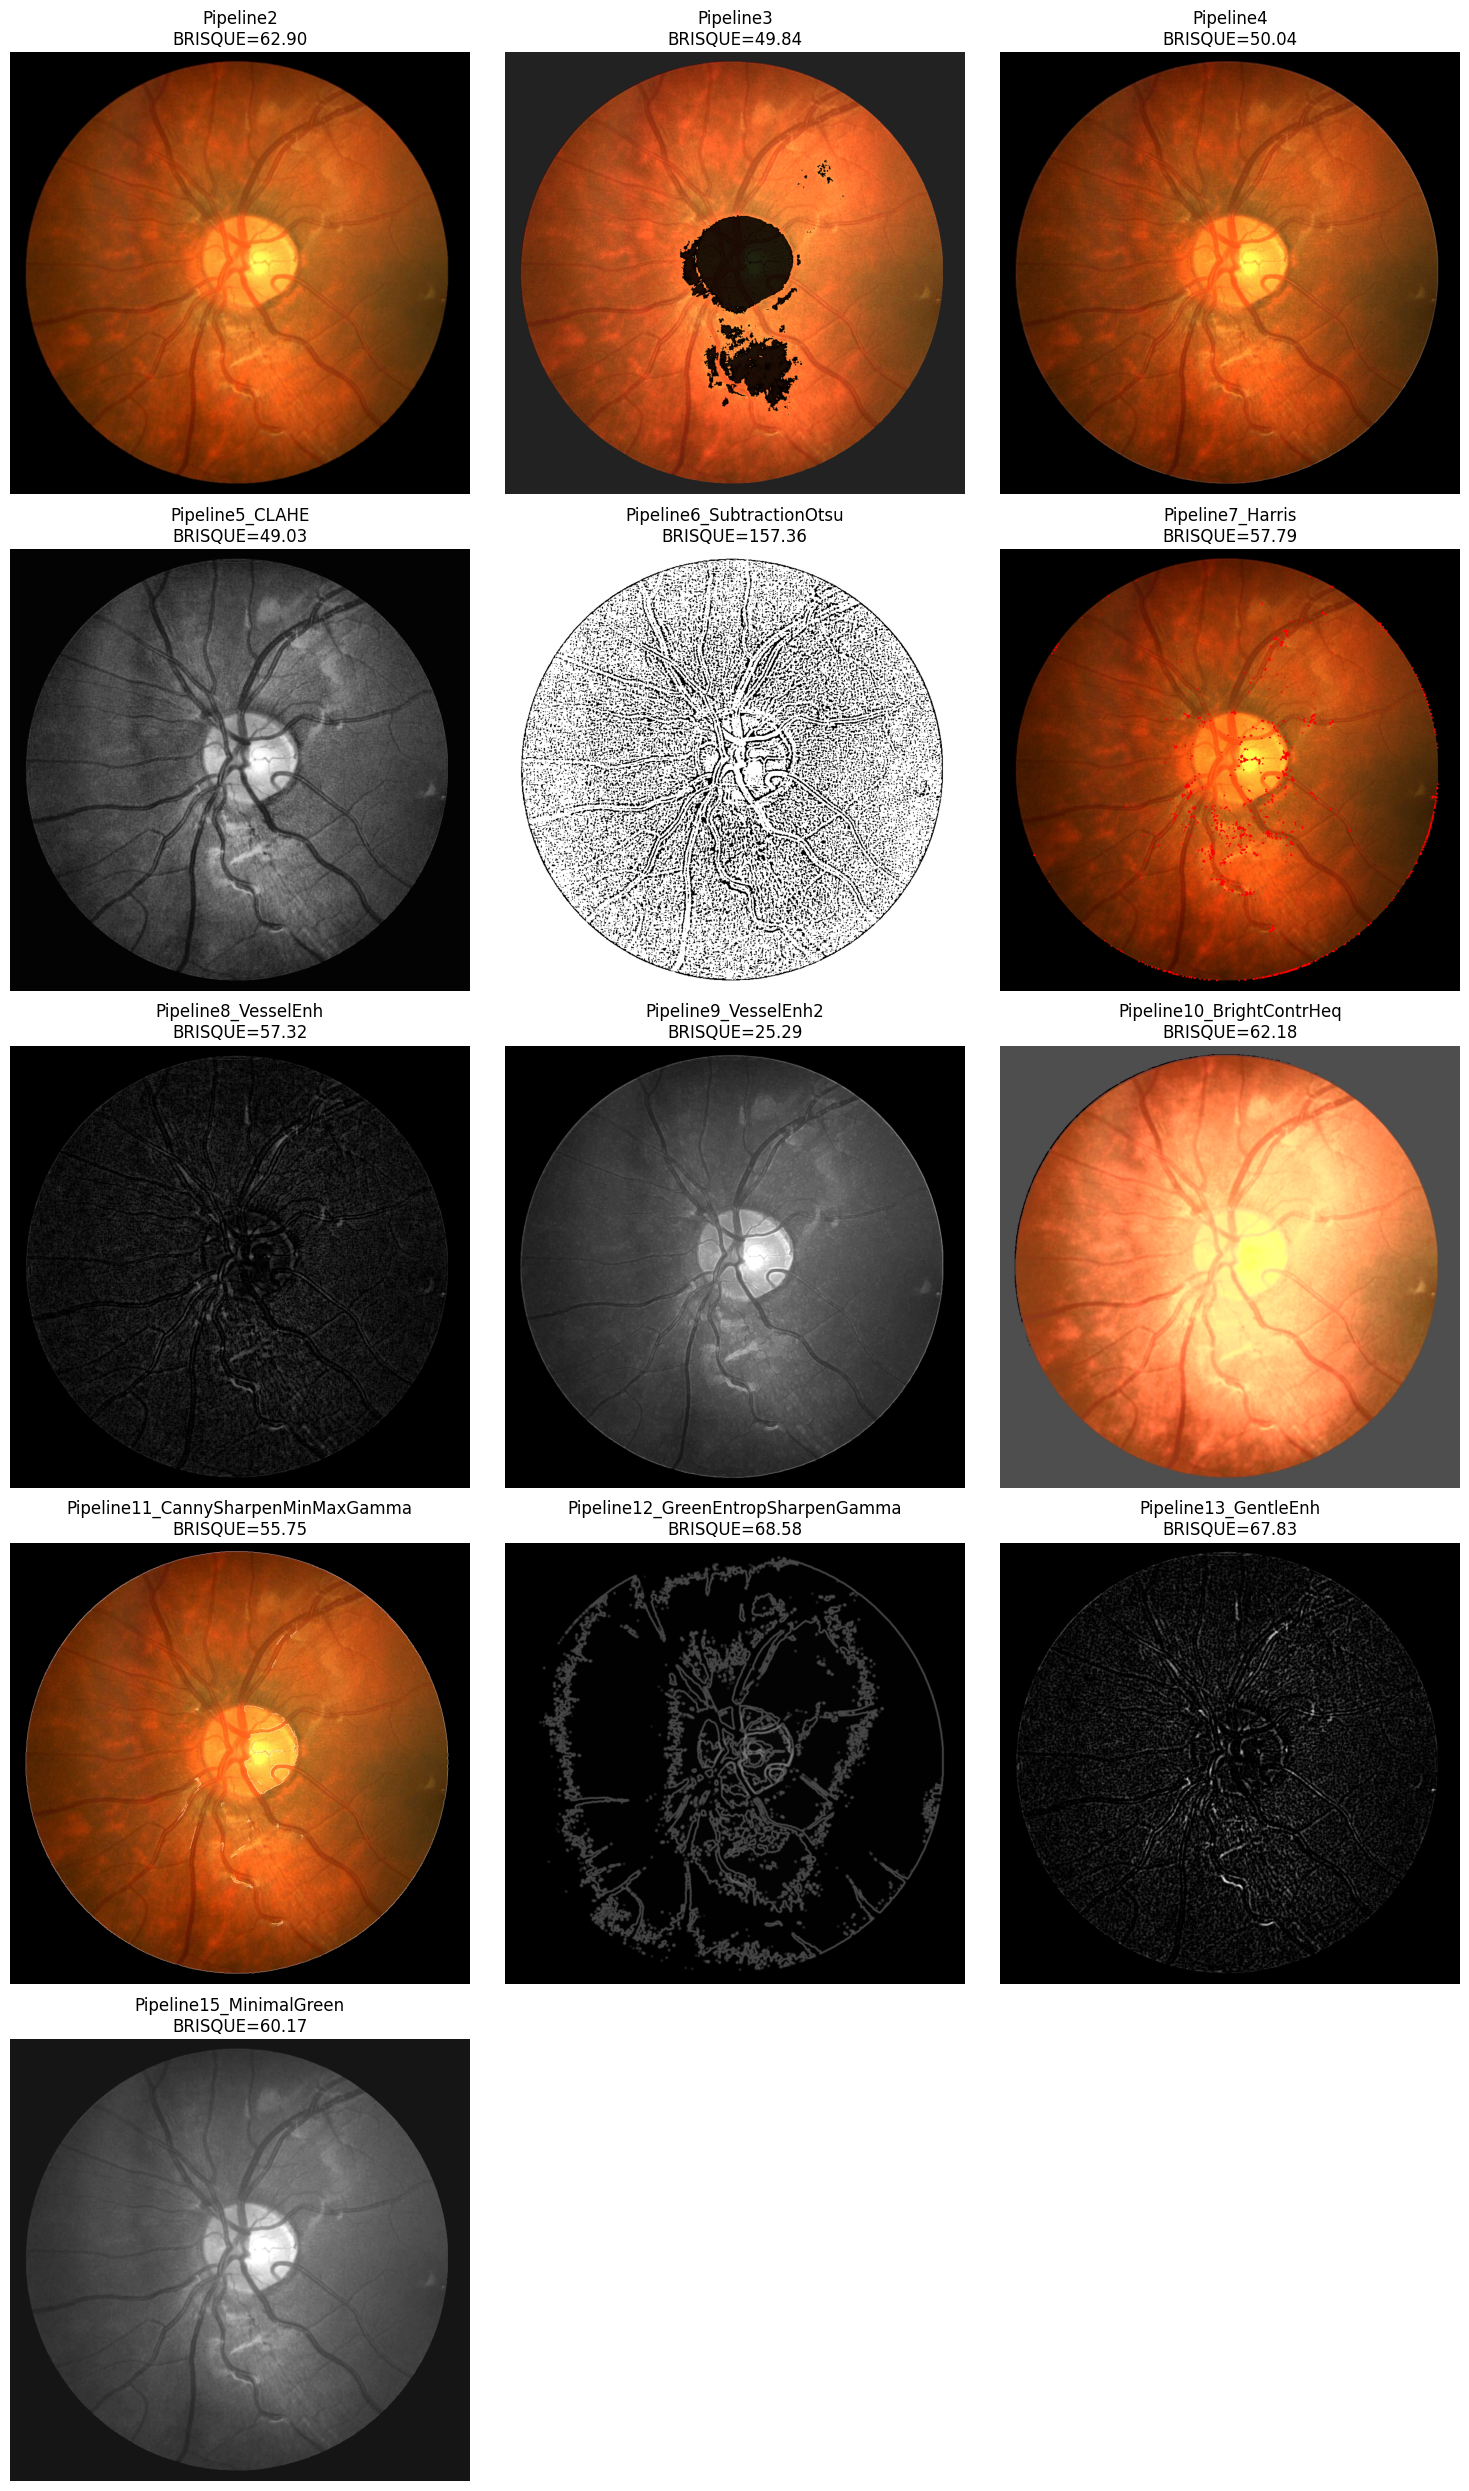


--- Pipeline Sonuçları ---
Pipeline2 -> 62.90
Pipeline3 -> 49.84
Pipeline4 -> 50.04
Pipeline5_CLAHE -> 49.03
Pipeline6_SubtractionOtsu -> 157.36
Pipeline7_Harris -> 57.79
Pipeline8_VesselEnh -> 57.32
Pipeline9_VesselEnh2 -> 25.29
Pipeline10_BrightContrHeq -> 62.18
Pipeline11_CannySharpenMinMaxGamma -> 55.75
Pipeline12_GreenEntropSharpenGamma -> 68.58
Pipeline13_GentleEnh -> 67.83
Pipeline15_MinimalGreen -> 60.17

En iyi Pipeline: Pipeline9_VesselEnh2, Skor=25.29


In [ ]:


# ... [Pipeline fonksiyonlarınız, compute_brisque_score, vs. tanımları] ...

# ===========================================
#  Veri Yolları
# ===========================================
image_folder = '/content/drive/MyDrive/katman/Training/Images'
mask_folder  = '/content/drive/MyDrive/katman/Training/Masks'

image_files = sorted([
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder) if f.endswith('.jpg')
])
mask_files = sorted([
    os.path.join(mask_folder, f)
    for f in os.listdir(mask_folder) if f.endswith('.png')
])

min_length = min(len(image_files), len(mask_files))
image_files = image_files[:min_length]
mask_files  = mask_files[:min_length]

if len(image_files) == 0:
    print("Görüntü bulunamadı!")
else:
    img_path  = image_files[0]
    mask_path = mask_files[0]

    print("Seçilen Görsel:", os.path.basename(img_path))

    # Görsel & Maske oku
    img  = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    # Maske uygula
    masked_img = apply_mask(img, mask)

    # ================================
    # Pipeline Listesine Ekleyin
    # ================================
    pipelines = [
        ("Pipeline2", pipeline2),
        ("Pipeline3", pipeline3),
        ("Pipeline4", pipeline4),
        ("Pipeline5_CLAHE", pipeline5_clahe),
        ("Pipeline6_SubtractionOtsu", pipeline6_subtraction_otsu),
        ("Pipeline7_Harris", pipeline7_harris),
        ("Pipeline8_VesselEnh", pipeline8_vessel),
        ("Pipeline9_VesselEnh2", pipeline9_vessel),
        ("Pipeline10_BrightContrHeq", pipeline10_bright_contrast_heq),
        ("Pipeline11_CannySharpenMinMaxGamma", pipeline11_canny_sharpen_minmax_gamma),
        ("Pipeline12_GreenEntropSharpenGamma", pipeline12_green_entropy_sharpen_gamma),
        ("Pipeline13_GentleEnh", pipeline13_gentle_enhancement),
        ("Pipeline15_MinimalGreen", pipeline15_minimal_green),
    ]

    # Her pipeline sonucu & skoru
    results = []
    for (pname, func) in pipelines:
        out = func(masked_img)
        score = compute_brisque_score(out)
        results.append((pname, out, score))

    # Burada "filtered_results" diyebilirsiniz veya direkt results üzerinde devam edebilirsiniz
    final_results = results  # Tüm sonuçlar veya eşiğe göre filtrelediğiniz sonuçlar

    if len(final_results) == 0:
        print("\nSonuç bulunamadı.")
    else:
        # Her satır 3 görüntü
        ncols = 3
        n = len(final_results)
        nrows = math.ceil(n / ncols)

        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

        # Tek satır/tek sütun durumlarını düzeltmek için:
        if nrows == 1 and ncols == 1:
            axs = [[axs]]
        elif nrows == 1:
            axs = [axs]
        elif ncols == 1:
            axs = [[ax] for ax in axs]

        for i, (pname, pimg, pscore) in enumerate(final_results):
            row = i // ncols
            col = i % ncols
            ax = axs[row][col]

            rgb = cv2.cvtColor(pimg, cv2.COLOR_BGR2RGB)
            ax.imshow(rgb)
            ax.set_axis_off()
            ax.set_title(f"{pname}\nBRISQUE={pscore:.2f}")

        # Kalan boş subplot'lar olabilir, onları gizleyelim
        total_plots = nrows * ncols
        for j in range(len(final_results), total_plots):
            r = j // ncols
            c = j % ncols
            axs[r][c].set_visible(False)

        plt.tight_layout()
        plt.show()

        # Terminal çıktısı
        print("\n--- Pipeline Sonuçları ---")
        for (pname, _, pscore) in final_results:
            print(f"{pname} -> {pscore:.2f}")

        # En iyi pipeline
        best_pipe = min(final_results, key=lambda x: x[2])
        print(f"\nEn iyi Pipeline: {best_pipe[0]}, Skor={best_pipe[2]:.2f}")


In [1]:
# Gerekli kütüphaneleri yükle
import os  # Dosya ve klasör işlemleri için kullanılır
import cv2  # Görüntü işleme fonksiyonlarını sağlar
import numpy as np  # Sayısal işlemler ve veri manipülasyonu için
from google.colab import drive  # Google Drive ile entegrasyon için
import matplotlib.pyplot as plt  # Görselleştirme araçları için
from skimage import color, exposure, morphology  # Görüntü işleme araçları
from skimage.filters import threshold_otsu  # Otsu eşikleme yöntemi için

# Google Drive'ı bağla
# İşlem yapılacak dosyalara Drive üzerinden erişmek için
drive.mount('/content/drive')

# TIF dosyalarının bulunduğu klasör yolunu belirtin
# Görüntülerin bulunduğu klasörün yolu
image_folder = '/content/drive/MyDrive/AV_groundTruth/test/images'

# .tif uzantılı dosyaları listele
# Klasör içindeki sadece .tif formatındaki dosyaları bulur
tif_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

Mounted at /content/drive


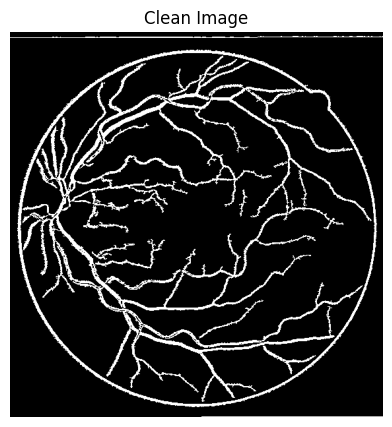

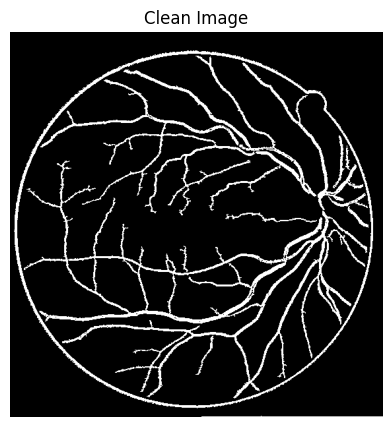

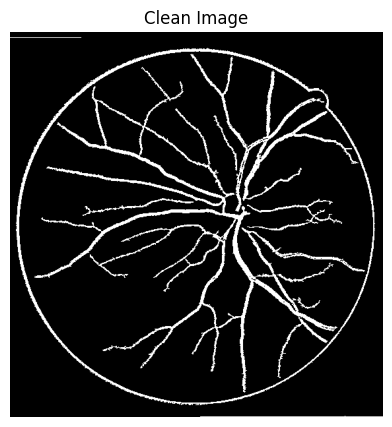

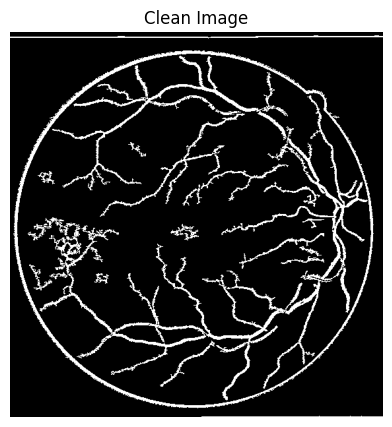

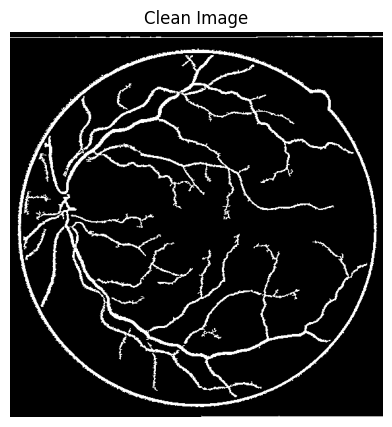

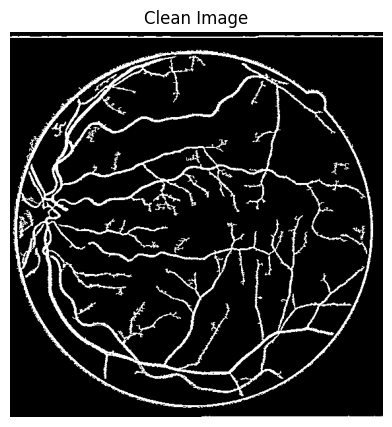

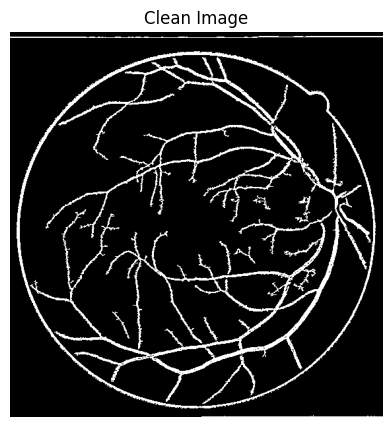

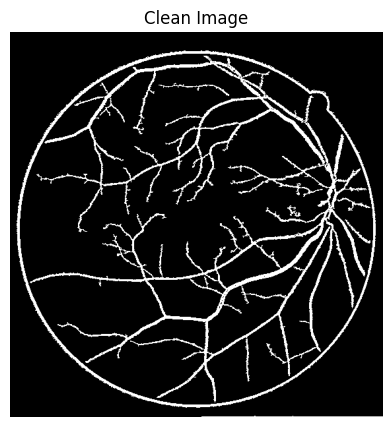

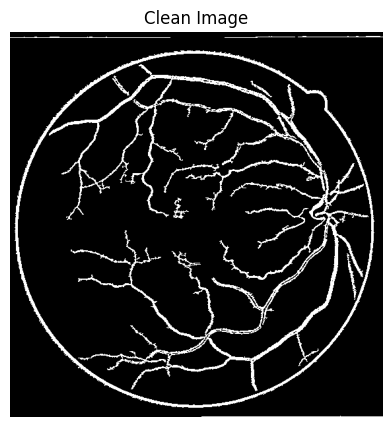

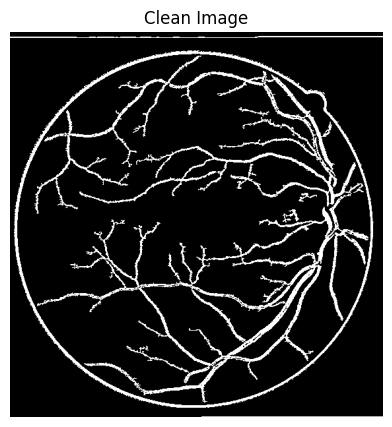

/content/drive/MyDrive/Clean_Images/clean_image_1.png kaydedildi.
/content/drive/MyDrive/Clean_Images/clean_image_2.png kaydedildi.
/content/drive/MyDrive/Clean_Images/clean_image_3.png kaydedildi.
/content/drive/MyDrive/Clean_Images/clean_image_4.png kaydedildi.
/content/drive/MyDrive/Clean_Images/clean_image_5.png kaydedildi.
/content/drive/MyDrive/Clean_Images/clean_image_6.png kaydedildi.
/content/drive/MyDrive/Clean_Images/clean_image_7.png kaydedildi.
/content/drive/MyDrive/Clean_Images/clean_image_8.png kaydedildi.
/content/drive/MyDrive/Clean_Images/clean_image_9.png kaydedildi.
/content/drive/MyDrive/Clean_Images/clean_image_10.png kaydedildi.
Tüm Clean Image'ler başarıyla kaydedildi!


In [3]:
for tif_file in tif_files:
    # Dosya yolunu oluştur
    file_path = os.path.join(image_folder, tif_file)

    # TIF dosyasını oku
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

    # Görüntüyü yeniden boyutlandır
    resized_image = cv2.resize(image, (565, 584))
    converted_image = resized_image / 255.0

    # RGB'yi LAB renk uzayına çevir ve LAB işlem
    lab_image = color.rgb2lab(converted_image)
    fill = np.array([1, 0, 0])
    filled_image = lab_image * fill
    reshaped_lab_image = filled_image.reshape(-1, 3)
    mean = np.mean(reshaped_lab_image, axis=0)
    centered_data = reshaped_lab_image - mean
    cov_matrix = np.cov(centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    principal_component = centered_data @ eigenvectors[:, -1]
    s = principal_component.reshape(lab_image.shape[:2])
    gray_image = (s - np.min(s)) / (np.max(s) - np.min(s))

    # Histogram eşitleme ve filtreleme
    enhanced_image = exposure.equalize_adapthist(gray_image, clip_limit=0.03, nbins=128)
    kernel = np.ones((9, 9), np.float32) / 81
    filtered_image = cv2.filter2D(enhanced_image, -1, kernel)
    subtracted_image = filtered_image - enhanced_image

    # Otsu eşikleme
    threshold_level = threshold_otsu(subtracted_image)
    binary_image = subtracted_image > (threshold_level - 0.008)

    # Görüntüyü temizleme
    clean_image = morphology.remove_small_objects(binary_image, min_size=100)

    # "Clean Image" Görüntüsünü Görüntüle
    plt.figure(figsize=(5, 5))
    plt.imshow(clean_image, cmap='gray')
    plt.title('Clean Image')
    plt.axis('off')
    plt.show()


import os  # Dosya işlemleri için
from skimage import img_as_ubyte  # Görüntü formatını kaydetmek için

# Kaydedilecek klasörü belirleyin
output_folder = '/content/drive/MyDrive/Clean_Images'  # Kaydedilecek klasör yolu
os.makedirs(output_folder, exist_ok=True)  # Klasör yoksa oluştur

for i, tif_file in enumerate(tif_files):
    # Dosya yolunu oluştur
    file_path = os.path.join(image_folder, tif_file)

    # TIF dosyasını oku
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

    # Görüntüyü yeniden boyutlandır
    resized_image = cv2.resize(image, (565, 584))
    converted_image = resized_image / 255.0

    # RGB'yi LAB renk uzayına çevir ve LAB işlem
    lab_image = color.rgb2lab(converted_image)
    fill = np.array([1, 0, 0])
    filled_image = lab_image * fill
    reshaped_lab_image = filled_image.reshape(-1, 3)
    mean = np.mean(reshaped_lab_image, axis=0)
    centered_data = reshaped_lab_image - mean
    cov_matrix = np.cov(centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    principal_component = centered_data @ eigenvectors[:, -1]
    s = principal_component.reshape(lab_image.shape[:2])
    gray_image = (s - np.min(s)) / (np.max(s) - np.min(s))

    # Histogram eşitleme ve filtreleme
    enhanced_image = exposure.equalize_adapthist(gray_image, clip_limit=0.03, nbins=128)
    kernel = np.ones((9, 9), np.float32) / 81
    filtered_image = cv2.filter2D(enhanced_image, -1, kernel)
    subtracted_image = filtered_image - enhanced_image

    # Otsu eşikleme
    threshold_level = threshold_otsu(subtracted_image)
    binary_image = subtracted_image > (threshold_level - 0.008)

    # Görüntüyü temizleme
    clean_image = morphology.remove_small_objects(binary_image, min_size=100)

    # Clean Image'i kaydet
    output_path = os.path.join(output_folder, f'clean_image_{i+1}.png')
    cv2.imwrite(output_path, img_as_ubyte(clean_image))  # Clean Image'i kaydet

    print(f'{output_path} kaydedildi.')

print("Tüm Clean Image'ler başarıyla kaydedildi!")

